# Intuit Quickbooks Upgrade

* Team-lead GitLab userid: qchu
* Group name: WonderFourEver


## 1. Introduction & Problem Identification

QuickBooks is an accounting software that can provide powerful bookkeeping capabilities to small businesses. In 1995, Version 3 for QuickBooks was released and the company had already sent them out in the first wave mailing with an offer to upgrade to the latest version.
In this project, we are asked to help Intuit determine which of the 22,500 businesses in the test set to mail in wave-2. The data we have contains 75,000 small businesses selected randomly from 801821 that were sent the wave-1 mailing. The models we use are RFM, Logistic regression, and Neural Network.


## 2. Exploratory Data Analysis

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import statsmodels.formula.api as smf
from sklearn import preprocessing
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit
import seaborn as sns
from scipy.stats import chisquare, chi2_contingency

# increase plot resolution
# mpl.rcParams["figure.dpi"] = 100

In [2]:
## loading the data - this dataset must NOT be changed
intuit75k = pd.read_pickle("data/intuit75k.pkl")
intuit75k["res1_yes"] = rsm.ifelse(intuit75k.res1 == "Yes", 1, 0)

In [3]:
intuit75k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   id          75000 non-null  int32   
 1   zip         75000 non-null  object  
 2   zip_bins    75000 non-null  int32   
 3   sex         75000 non-null  category
 4   bizflag     75000 non-null  int32   
 5   numords     75000 non-null  int32   
 6   dollars     75000 non-null  float64 
 7   last        75000 non-null  int32   
 8   sincepurch  75000 non-null  int32   
 9   version1    75000 non-null  int32   
 10  owntaxprod  75000 non-null  int32   
 11  upgraded    75000 non-null  int32   
 12  res1        75000 non-null  category
 13  training    75000 non-null  int32   
 14  res1_yes    75000 non-null  int64   
dtypes: category(2), float64(1), int32(10), int64(1), object(1)
memory usage: 4.7+ MB


In [4]:
intuit75k.head()

,id,zip,zip_bins,sex,bizflag,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1,training,res1_yes
0,1,94553,18,Male,0,2,109.5,5,12,0,0,0,No,1,0
1,2,53190,10,Unknown,0,1,69.5,4,3,0,0,0,No,0,0
2,3,37091,8,Male,0,4,93.0,14,29,0,0,1,No,0,0
3,4,02125,1,Male,0,1,22.0,17,1,0,0,0,No,1,0
4,5,60201,11,Male,0,1,24.5,2,3,0,0,0,No,0,0


### 2.1 Zip and zip_bins

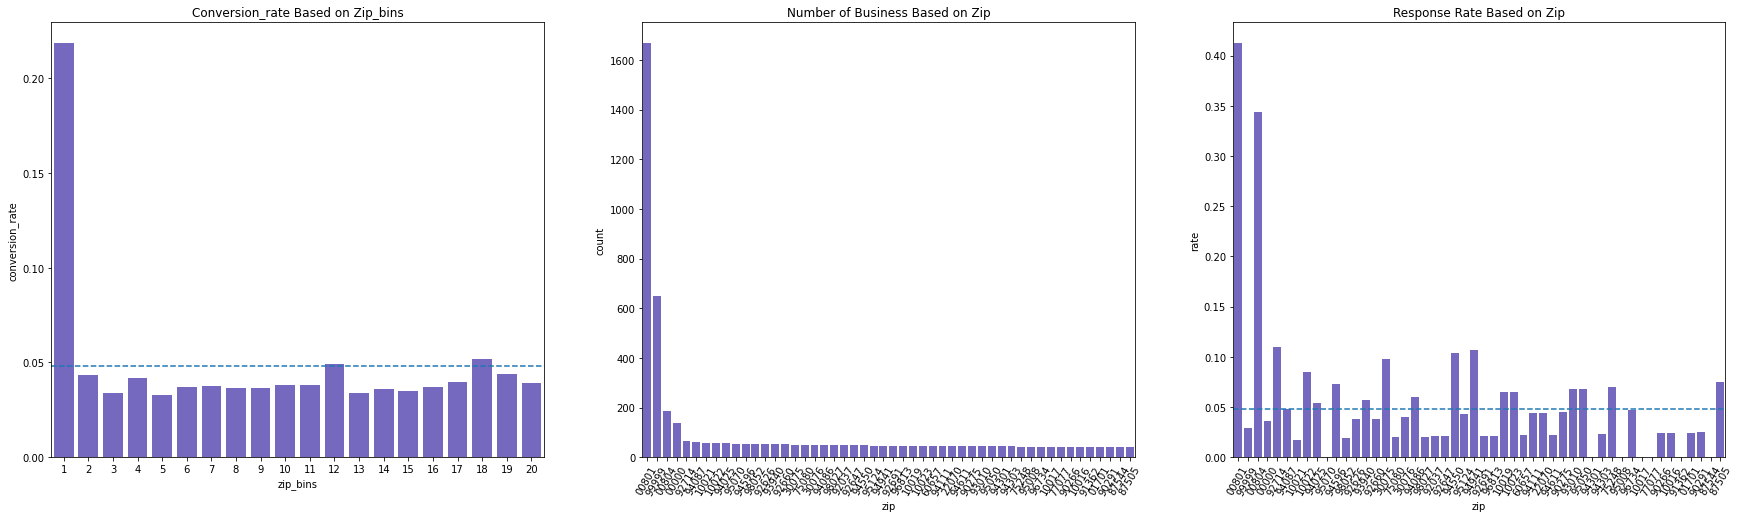

In [5]:
df = intuit75k.groupby(['zip']).res1_yes.agg(['count','sum']).copy()
df = df.sort_values(by=['count'],ascending = False).reset_index()[:50]
df['rate'] = df['sum']/df['count']
fig, axs = plt.subplots(1, 3, figsize = (30, 8))
df2 = intuit75k.groupby(['zip_bins']).res1_yes.agg(['count','sum']).reset_index().copy()
df2['conversion_rate'] = df2['sum']/df2['count']
sns.barplot(x= 'zip_bins',y = 'conversion_rate',data = df2,color = 'slateblue', ax = axs[0])
axs[0].axhline(0.04801333333333333,linestyle = '--')
axs[0] = axs[0].set_title('Conversion_rate Based on Zip_bins')
sns.barplot(x= 'zip',y = 'count',data = df,color = 'slateblue', ax = axs[1])
axs[1].set_xticklabels(axs[1].get_xticklabels(),rotation = 60)
axs[1].set_title('Number of Business Based on Zip')
sns.barplot(x= 'zip',y = 'rate',data = df, color = 'slateblue', ax = axs[2])
axs[2].set_xticklabels(axs[2].get_xticklabels(),rotation = 60)
axs[2].axhline(0.04801333333333333,linestyle = '--')
axs[2].set_title('Response Rate Based on Zip')
plt.show()

As we can see from the above barchart, zip_bin 1 has a conversion rate significantly higher than other zip_bins. 

Therefore, we take a further look at the exact frequency distribution of zipcode and the response rate within each zipcode. We found that zip code '00801' and '99999' have stronger presence in the dataset compared with other zipcodes. In terms of response rate, zip code '00801' and '00804' have response rates that are significantly higher than the average response rate of the dataset(the dash blue line). Based on research, 00801 and 00804 are all zip codes within the United States Virgin Islands. Forming a corporation in the US Virgin Islands (USVI) provides many benefits and one of the most important could be tax advantages. According to USVI EDA, qualifying companies are eligible for 90% reduction in corporate income tax, 90% reduction in personal income tax, 100% exemption on excise tax and etc. This implies that Zipbins could be an important variable for our model and businesses with heavier tax liabilities maybe more likely to respond.


### 2.2 OwnTaxProd, Version1, Upgraded

**OwnTaxProd**

In [6]:
df = intuit75k.groupby("owntaxprod").agg(res1_yes = ("res1_yes", np.sum), total = ("res1_yes", "count")).copy()
df['res1_yes_prop'] = df.res1_yes / df.res1_yes.sum()
df['total_prop'] = df.total / df.total.sum()
df['res_rate'] = df.res1_yes / df.total
df['avg_res_rate'] = df['res1_yes'].sum() / df['total'].sum()
df['TGI'] = df.res1_yes_prop / df.total_prop
df.sort_values(by='res_rate', ascending = False).reset_index()

,owntaxprod,res1_yes,total,res1_yes_prop,total_prop,res_rate,avg_res_rate,TGI
0,1,181,2152,0.050264,0.028693,0.084108,0.048013,1.751759
1,0,3420,72848,0.949736,0.971307,0.046947,0.048013,0.977792


According to the table we can notice a significant difference in the response rate for customers whether they own a tax product or not. So we assume this variable could be important in our model.

**Veresion1**

In [7]:
df = intuit75k.groupby("version1").agg(res1_yes = ("res1_yes", np.sum), total = ("res1_yes", "count")).copy()
df['res1_yes_prop'] = df.res1_yes / df.res1_yes.sum()
df['total_prop'] = df.total / df.total.sum()
df['res_rate'] = df.res1_yes / df.total
df['avg_res_rate'] = df['res1_yes'].sum() / df['total'].sum()
df['TGI'] = df.res1_yes_prop / df.total_prop
df.sort_values(by='res_rate', ascending = False).reset_index()

,version1,res1_yes,total,res1_yes_prop,total_prop,res_rate,avg_res_rate,TGI
0,1,1058,16050,0.293807,0.214,0.065919,0.048013,1.372931
1,0,2543,58950,0.706193,0.786,0.043138,0.048013,0.898464


As we can see in the above bar chart, compared with businesses that are currently using version 2 of Quickbooks, businesses currently using version 1 have a much higher response rate.

**Upgraded**

In [8]:
df = intuit75k.groupby("upgraded").agg(res1_yes = ("res1_yes", np.sum), total = ("res1_yes", "count")).copy()
df['res1_yes_prop'] = df.res1_yes / df.res1_yes.sum()
df['total_prop'] = df.total / df.total.sum()
df['res_rate'] = df.res1_yes / df.total
df['avg_res_rate'] = df['res1_yes'].sum() / df['total'].sum()
df['TGI'] = df.res1_yes_prop / df.total_prop
df.sort_values(by='res_rate', ascending = False).reset_index()

,upgraded,res1_yes,total,res1_yes_prop,total_prop,res_rate,avg_res_rate,TGI
0,1,1185,15629,0.329075,0.208387,0.075821,0.048013,1.579157
1,0,2416,59371,0.670925,0.791613,0.040693,0.048013,0.847541


As we can see in the above bar chart, compared with businesses that did not upgrade from version1 to version2, businesses that have upgraded have a much higher response rate. 

### 2.3 Interactions among OwnTaxProd, Version1, Upgraded

The previous analysis exhibits that the variables “Owntaxprod”, “Version1” and “Upgrade” have a positive impact on the response rate. To examine the inherent possible relationships among these variables, we ran a Chi-Squared Test and pivot table analysis to find out the most impactful predictor and potential interactions.

In [9]:
variables = []
cs = []
ps = []
dofs = []

variables.append('version1, owntaxprod')
ct = pd.crosstab(intuit75k['version1'], intuit75k['owntaxprod'])
c, p, dof, expected = chi2_contingency(ct)
cs.append(c)
ps.append(p)
dofs.append(dof)

variables.append('version1, upgraded')
ct = pd.crosstab(intuit75k['version1'], intuit75k['upgraded'])
c, p, dof, expected = chi2_contingency(ct)
cs.append(c)
ps.append(p)
dofs.append(dof)

variables.append('upgraded, owntaxprod')
ct = pd.crosstab(intuit75k['upgraded'], intuit75k['owntaxprod'])
c, p, dof, expected = chi2_contingency(ct)
cs.append(c)
ps.append(p)
dofs.append(dof)

pd.DataFrame(zip(variables, cs, ps, dofs), columns = ['variables', 'Chi-squared', 'p-value', 'Degree of freedom']).round(4)

,variables,Chi-squared,p-value,Degree of freedom
0,"version1, owntaxprod",538.2691,0.0,1
1,"version1, upgraded",5373.7748,0.0,1
2,"upgraded, owntaxprod",571.8548,0.0,1


From the Chi-squared test above, we can see that the p-values are all smaller than .001, therefore we should reject the null hypotheses that these three are independent of each other. 

**Upgraded X Version1**

In [10]:
df = intuit75k.groupby(['upgraded', 'version1']).agg(res1_yes = ("res1_yes", "sum"), total = ("res1_yes", "count")).reset_index()
df['res1_yes_prop'] = df.res1_yes / df.res1_yes.sum()
df['total_prop'] = df.total / df.total.sum()
df['res_rate'] = df.res1_yes / df.total
df['avg_res_rate'] = intuit75k.res1_yes.sum() / intuit75k.res1_yes.count()
df['TGI'] = df.res1_yes_prop / df.total_prop * 100
df.sort_values(by = "res_rate", ascending = False, inplace = True)
df = df.round(4)
df

,upgraded,version1,res1_yes,total,res1_yes_prop,total_prop,res_rate,avg_res_rate,TGI
2,1,0,1185,15629,0.3291,0.2084,0.0758,0.048,157.9157
1,0,1,1058,16050,0.2938,0.2140,0.0659,0.048,137.2931
0,0,0,1358,43321,0.3771,0.5776,0.0313,0.048,65.2889


From the pivot table, we could see that no businesses which are currently using version1 have upgraded. Among the rest of the three types, people who have upgraded from version1 and currently are using version2(upgraded = 1 & version1 = 0) have the highest response rate(7.58% compared to an average of 4.8%). The second likely to respond are those who are currently using version1 and haven’t upgraded since their purchase(upgraded = 0 & version1 = 1), their response rate is 6.59% and is much higher than the average response rate(4.8%). People who are currently using version2(upgraded = 0 & version1 = 0) are less likely to respond.(response rate of 3.13%, avg = 4.8%)

**OwnTaxProd X Version1**

In [11]:
df = intuit75k.groupby(['owntaxprod', 'version1']).agg(res1_yes = ("res1_yes", "sum"), total = ("res1_yes", "count")).reset_index()
df['res1_yes_prop'] = df.res1_yes / df.res1_yes.sum()
df['total_prop'] = df.total / df.total.sum()
df['res_rate'] = df.res1_yes / df.total
df['avg_res_rate'] = intuit75k.res1_yes.sum() / intuit75k.res1_yes.count()
df['TGI'] = df.res1_yes_prop / df.total_prop * 100
df.sort_values(by = "res_rate", ascending = False, inplace = True)
df = df.round(4)
df

,owntaxprod,version1,res1_yes,total,res1_yes_prop,total_prop,res_rate,avg_res_rate,TGI
2,1,0,180,2127,0.0500,0.0284,0.0846,0.048,176.2557
1,0,1,1057,16025,0.2935,0.2137,0.0660,0.048,137.3773
0,0,0,2363,56823,0.6562,0.7576,0.0416,0.048,86.6119
3,1,1,1,25,0.0003,0.0003,0.0400,0.048,83.3102


We see from the below table that people who own tax products and are using version2(owntaxprod = 1 & version1 = 0) or the vice vesera(owntaxprod = 0 & version1 = 0) have a response rate higher than the average. Interactions between owntaxprod and version1 might exist but given that the total number of businesses belong to this category are too smal(total = 25), the analysis result might not be statistically significant to reveal useful information.

**OwnTaxProd X Version1**

In [12]:
df = intuit75k.groupby(['owntaxprod', 'version1']).agg(res1_yes = ("res1_yes", "sum"), total = ("res1_yes", "count")).reset_index()
df['res1_yes_prop'] = df.res1_yes / df.res1_yes.sum()
df['total_prop'] = df.total / df.total.sum()
df['res_rate'] = df.res1_yes / df.total
df['avg_res_rate'] = intuit75k.res1_yes.sum() / intuit75k.res1_yes.count()
df['TGI'] = df.res1_yes_prop / df.total_prop * 100
df.sort_values(by = "res_rate", ascending = False, inplace = True)
df = df.round(4)
df

,owntaxprod,version1,res1_yes,total,res1_yes_prop,total_prop,res_rate,avg_res_rate,TGI
2,1,0,180,2127,0.0500,0.0284,0.0846,0.048,176.2557
1,0,1,1057,16025,0.2935,0.2137,0.0660,0.048,137.3773
0,0,0,2363,56823,0.6562,0.7576,0.0416,0.048,86.6119
3,1,1,1,25,0.0003,0.0003,0.0400,0.048,83.3102


From the table, we can see that the variable “upgraded” is very impactful to the response rate, and people who purchased tax products and have upgraded have the highest response rate than the others. Interactions between these two variables might exist. 

Therefore, we can conclude from the above analysis that:
- The three variables are not independent from each other: Interaction between owntaxprod and upgraded exists and might have a predictive impact on the response rate. 
- Businesses either are using verson1 or have upgraded have an above-average response rate. 
- Upgraded and owntaxprod could be variables that are more impactful.

**Summary**

Based on the EDA, we could infer that businesses in zip code '00801' and '00804' (or zip_bin 1),purchased tax products previously, upgraded from quickbooks version1 and currently are using version2 are more likely to upgrade.

These variables indicate certain characteristics of business. Businesses that have heavier tax liabilities or accounting needs are more likely to upgrade since the quickbook can be a critical tool for their business. Businesses that used quickbook for a longer time and previously upgraded are more likely to upgrade this time as they could be our loyal customers.


## 3. Model Design & Feature Engineering

### 3.1 Model Assumption

- **Breakeven rate**: 
    Based on the financial information provided in the case(mail costs of \\$1.41 and margin of each responder $60), we calculated the breakeven to be 0.0235.
- **Customer behavior**:
    We assume that purchase behaviors of customers remain the same for wave1 and wave2 campaign, therefore we could predict response probability of businesses based on the data of the wave1.
- **Wave2 response rate**: 
    Given the cusomter behavior assumption, we assume every response probability in wave-2 is only 50% of the response probability we predict for that business based on
the wave-1 response data. We would compare the wave2 response rate with the breakeven rate above to determine whether to mail during wave2 campaign.


## 3.2 Feature Engineering

### 3.2.1 New Variables

Based on the exploratory data analysis(EDA) above and the models we are going to apply(RFM, Logistic Regression, and Neural Network), we could add a few variables to our model:

<table class='table table-condensed table-hover' style='width:100%;'>
 <thead>
     <tr>
   <th style="text-align:left;"> Variables </th>
   <th style="text-align:left;"> Definition </th>
   <th style="text-align:left;"> Explanation </th>
      </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> avg_dollar</td>
   <td style="text-align:left;"> dollar / numords </td>
   <td style="text-align:left;"> Average dollar value of each order </td>
  </tr>
    
   <tr>
   <td style="text-align:left;"> version1_upgraded</td>
   <td style="text-align:left;"> version1 + upgraded</td>
   <td style="text-align:left;"> From the EDA, we know that either people who have upgraded or are using version1 are more likely to respond. This variable is intended to capture this information. </td>
  </tr>

  <tr>
   <td style="text-align:left;"> zipbins_yes</td>
   <td style="text-align:left;"> ifelse(zip_bins == 1, 1, 0) </td>
   <td style="text-align:left;"> From the EDA, we noticed that zipbins 1 has largest response rate. </td>
  </tr>
    
   <tr>
   <td style="text-align:left;"> zip_yes</td>
   <td style="text-align:left;"> ifelse(zip == ‘00801’,1, 0) </td>
   <td style="text-align:left;"> From the EDA, we discovered that business that has a zip code of 00801 has the highest response rate.</td>
  </tr>
    
<tr>
   <td style="text-align:left;"> recency_tile</td>
   <td style="text-align:left;"> xtile of last </td>
   <td style="text-align:left;">For RFM analysis </td>
  </tr>

    
   <tr>
   <td style="text-align:left;"> frequency_tile</td>
   <td style="text-align:left;"> xtile of numords </td>
   <td style="text-align:left;"> For RFM analysis </td>
  </tr>
    
   <tr>
   <td style="text-align:left;"> monetary_tile</td>
   <td style="text-align:left;"> xtile of dollars / avg_dollar </td>
   <td style="text-align:left;"> For RFM analysis </td>
  </tr>
    
</tbody>
</table>

### 3.2.2 Preprocessing Technique

Normally, different models require different types of preprocessing. The one we will be using for our models are listed and discussed as below:
- **Data Type Tranformation**

    This applies to all the models. Besides the four numeric variables(numords, dollars, last, sincepurch), we transfer all the categorical variables to data type of category.
- **Onehot Encoding**

    The model we will be using is RFM, Logistic Regression(LR) and Neural Networks(NN). The latter two will take the categorical data as input. Since our categorical variables are not ordinal, and LR and NN do not have the tree model’s processing ability of categorical data, we should transform the categorical data using onehot encoding.
- **Scaling**
    
    Scaling helps models converge faster and is good for interpretation. The scaling technique we will be using is minmax normalization and standardization, depending on the model.

#### Feature Table

<table class='table table-condensed table-hover' style='width:100%;'>
 <thead>
     <tr>
   <th style="text-align:left;"> Category </th>
   <th style="text-align:left;"> Variable </th>
   <th style="text-align:left;"> Type </th>
      </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> Demographics</td>
   <td style="text-align:left;"> zip </td>
   <td style="text-align:left;"> category </td>
  </tr>
    
  <tr>
   <td style="text-align:left;"> </td>
   <td style="text-align:left;"> zip_bins </td>
   <td style="text-align:left;"> category </td>
  </tr>

   <tr>
   <td style="text-align:left;"> </td>
   <td style="text-align:left;"> sex </td>
   <td style="text-align:left;"> category </td>
  </tr>

  <tr>
   <td style="text-align:left;"> </td>
   <td style="text-align:left;"> bizflag </td>
   <td style="text-align:left;"> category </td>
  </tr>
  <tr>
   <td style="text-align:left;"> Purchase Behavior(RFM Related)</td>
   <td style="text-align:left;"> numords </td>
   <td style="text-align:left;"> numeric </td>
  </tr>    
  <tr>
   <td style="text-align:left;"> </td>
   <td style="text-align:left;"> dollars </td>
   <td style="text-align:left;"> numeric </td>
  </tr>        
   <tr>
   <td style="text-align:left;"> </td>
   <td style="text-align:left;"> last </td>
   <td style="text-align:left;"> numeric </td>
  </tr>
    <tr>
   <td style="text-align:left;"> </td>
   <td style="text-align:left;"> sincepurch </td>
   <td style="text-align:left;"> numeric </td>
  </tr>
  <tr>
   <td style="text-align:left;"> New Variables</td>
   <td style="text-align:left;"> avg_dollar</td>
   <td style="text-align:left;"> numeric</tr>    
   <tr>
   <td style="text-align:left;"> </td>
   <td style="text-align:left;"> version1_upgraded</td>
   <td style="text-align:left;"> category</tr>
<tr>
   <td style="text-align:left;"> </td>
   <td style="text-align:left;"> zipbins_yes </td>
   <td style="text-align:left;"> category</td>
  </tr>
<tr>
   <td style="text-align:left;"> </td>
   <td style="text-align:left;"> zip_yes </td>
   <td style="text-align:left;"> category</td>
  </tr>
    
<tr>
   <td style="text-align:left;"> </td>
   <td style="text-align:left;"> recency_tile</td>
   <td style="text-align:left;"> category</td>
  </tr>

    
   <tr>
   <td style="text-align:left;"> </td>
   <td style="text-align:left;"> frequency_title</td>
   <td style="text-align:left;"> category </td>
  </tr>
    
   <tr>
   <td style="text-align:left;"> </td>
   <td style="text-align:left;"> monetary_title(avg_dollar) </td>
   <td style="text-align:left;"> category </td>
  </tr>
    
</tbody>
</table>

## 3.3 Model Design

### 3.3.1 RFM

Traditionally, the variables in the RFM (Recency, Frequency, Monetary) model refer to "last", "numords" and "dollars" variables in this dataset. Since we discovered a correlation of 0.58 between “dollars” and “numborders” and in order to prevent recency, frequency and monetary term in the model from capturing the same underlying behavioral characteristic, we divide the variable “dollar” by the “numords to get the average dollar per order and use it as the Monetary term in RFM analysis.

we created 4 different types of RFM group (Independent RFM,Sequential RFM, Independent RFM with adjusted standard error of response rate, Sequential RFM with adjusted standard error) based on the total dataset and calculated their corresponding response rate based on train data. Later in the testset, we only mail to businesses within RFM groups that have a response rate higher than the breakeven rate and calculate w1 profits based on it. 	

### 3.3.2 Logistic Regression

Firstly, we performed data preprocessing. For five variables(‘numords’, ‘dollars’, ‘last’ , ‘sincepurch’), we did standardization. For categorical variables, we transformed their data type to be ‘category’. Then we fitted the logit model with all explanatory variables and utilized odds-ratios and p-values to find out insignificant or unimportant variables and tried re-fitting logit models that excluded these variables. 

Additionally, we utilized L1-regularization(lasso) in sklearn for variable selection. For lasso, we used grid search and cross validation to find out the best regularization strength parameter. For parameters tuning, we self-defined a profit_score function(TP * margin - FP * cost) to be our performance evaluation to choose the best parameter. After that, we re-fitted a logit model with the selected variables using statsmodels.

### 3.3.3 Neural Networks

We will be using both the sklearn and keras packages to implement the neural network. The Multi-layer Perception from sklearn is used for searching and narrowing down the range of the hyper-parameters. The more flexible neural network by keras will be fine-tuning the hyper-parameters to try to get better performance.

In feature engineering, we will adopt all the variables mentioned above. The RFM xtitle we will be using comes from the sequential model, which outperforms the others. For numeric data, we will adopt the min-max normalization to scale all the variables between 0 and 1 to help the model converge faster. For categorical variables, we adopt onehot encoding technique to help the model better understand the data.

In tuning the model of sklearn neural netwrok, we will be using the profit function(defined by profit = tp * margin - fp * cost) to evaluate the model and search for suitable hyperparameters. Since it’s inconclusive what’s the best design of hidden layer size, we will compare the model using the one getting from GridSearchCV and the empirical experience. The empirical experience rules of hidden layer size can be denoted:

$$ (1)\ h = log_2n $$

$$ (2)\ h = \sqrt{m+n}+a, \ a \in I and \ a \in [1, 10] $$

$$ (3)\ h = 2 \times n + 1, \ a \in I and \ a \in [1, 10] $$

where $h$ equals to the size of the hidden layer, $n$ denotes the dimension of inputs, $m$ denotes the dimension of the output.

Then with the best parameters, we will apply them in the keras neural network to fine-tuning the model. 

To avoid overfitting, we will use 10% of the training dataset as validation dataset and apply early stopping when the loss function does not improve after 10 iterations in sklearn model. In keras mode, we use 10% as batch size and 100 as number of epochs and  20% of the training as the validation. We also add two dropout layers into the structure. 

To deal with the cold-start problem, we tried a few kernel initializers and decided to use “normal” in the end.


## 4. Model Performance & Analysis

### 4.1 Evaluation Metrics

- Profit:  Revenue from responders - mailing cost of customers we targeted, means the amount of money made from the campaign.
- ROME: Profit / mailing costs, measures the efficiency of the targeting campaign.
- F1-score: 2 * precision * recall / (precision + recall), focus on both precision and recall. Recall measures the ability to find all potentially responded customers.  
- Precision: TP / (TP + FP), represents the targeting accuracy for responded customers.

### 4.2 Model Evaluation

#### 4.2.1 RFM

In [13]:
%run ./sub-notebooks/rfm.ipynb

In [14]:
output_df_rfm

,i_quantiles,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC,i_quantiles
0,5,iq_rate,994,17480,3917,109,22500,0.901,0.183,0.054,0.102,0.218,0.010,33591.66,1.0,1.290,0.821,0.650,5
0,5,sq_rate,994,17546,3851,109,22500,0.901,0.180,0.054,0.101,0.215,0.010,33498.60,1.0,1.281,0.824,0.649,5
0,6,iq_rate,999,17940,3457,104,22500,0.906,0.162,0.053,0.100,0.198,0.008,33236.01,1.0,1.245,0.842,0.643,6
0,6,sq_rate,984,17365,4032,119,22500,0.892,0.188,0.054,0.101,0.223,0.010,33167.91,1.0,1.282,0.816,0.639,6
0,7,iq_rate,985,17356,4041,118,22500,0.893,0.189,0.054,0.101,0.223,0.010,33239.19,1.0,1.285,0.815,0.636,7
0,7,sq_rate,995,17635,3762,108,22500,0.902,0.176,0.053,0.101,0.211,0.009,33431.70,1.0,1.273,0.828,0.630,7


We experiment various quantiles, 5 quantiles still has the best profit and AUC performance compared with others. Since the profit difference between Independent RFM and Sequential RFM is relatively small, we choose the sequential RFM since it generates a more even distribution of RFM group if given a dataset.

#### 4.2.2 Logistic Regression

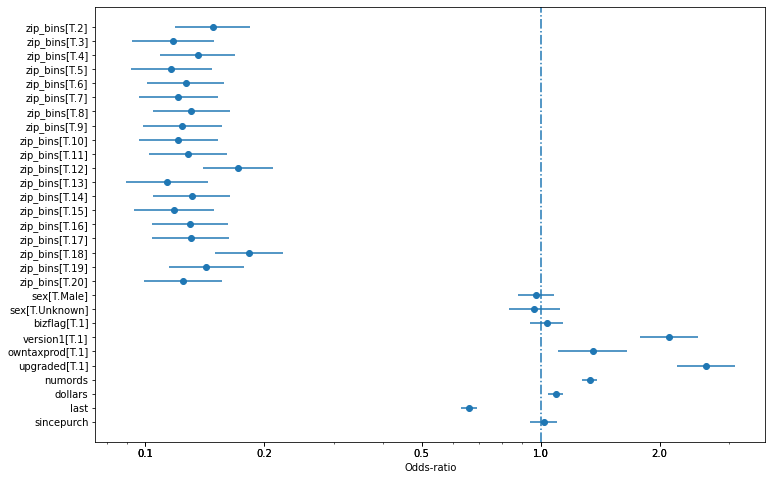

In [15]:
%run ./sub-notebooks/Logit.ipynb

In [16]:
lr[['Feature_selection', 'profit', 'ROME']]

,Feature_selection,profit,ROME
0,Odds_ratios,38665.98,1.914724
0,Lasso,38657.52,1.913504


After getting two models obtained by using two feature selection methods, we compared the wave-1 profit and ROME on the test set. We found that the model of selecting features based on odds-ratios has both higher profits and ROME. Therefore, we selected that one to be our best logit model. The best model is: "res1_yes ~ zip_bins + bizflag + numords + dollars + last + version1 + owntaxprod + upgraded". We deleted ‘sincepur’ and ‘sex’ since they are the most insignificant and unimportant variables.

#### 4.2.3 Neural Networks

**sklearn**

In [17]:
%run ./sub-notebooks/sklearn_MLP.ipynb

In [18]:
sklearn_eval = pd.concat([exp_params, best_params_df])
sklearn_eval['predictor'] = ['exp_params', 'best_params']
sklearn_eval

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,All,exp_params,970,13125,8272,133,22500,0.879,0.387,0.069,0.128,0.411,0.040,38326.05,1.0,1.928,0.626,0.760
0,All,best_params,986,14338,7059,117,22500,0.894,0.330,0.064,0.120,0.358,0.031,37553.16,1.0,1.738,0.681,0.758


Experience Params Feature Permutation Importance

![Feature Importance Exp](images/Feature_Importances_exp_clf.png)


Best GridSearchCV Params Feature Permutation Importance

![Feature Importance CV](images/Feature_Importances_cv_best_clf.png)

- From the evaluation table below, we could see that the two mlp classifiers from the sklearn have very similar performances in profit. The experiment params model slightly outperform the other in most evaluation metrics. 

- When we examine the feature importance using the permutation importance, we notice that the latter one(best gridsearchcv model) has a higher model complexity and a higher cost in model explaining.

- Given the above reason, we decided that the experience params mlp model is the better one.

**Keras**

In [19]:
%run ./sub-notebooks/keras_MLP.ipynb

In [20]:
print("Evaluation can be shown using the below table and plots: ")
best_keras_eval

Evaluation can be shown using the below table and plots: 


,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,All,ypred,961,12866,8531,142,22500,0.871,0.399,0.07,0.129,0.422,0.042,38163.93,1.0,1.958,0.615,0.764


![Loss](images/Loss_Keras_NN.png)

![Keras Perforamnce](images/Performance_Keras_NN.png)

The training progress can be visualized and presented as the plot shown above. We can see that after around 20 epochs, the profit on the test dataset improved significantly and became stable after approximately 100 epochs.

We also compute the permutation feature importance and found a bit hard to explain of the mlp model.

![Feature Importance keras](images/Permutation_Imporatances_Keras_NN.png)

Given that the profit of the keras is less than the sklearn experience params model and the its cost of model explanation is higher as well. we would adopt the experience parameters as the best MLP model to be compared to other models.

### 4.3 Model Comparison

In [21]:
intuit75k_test = intuit75k[intuit75k['training'] == 0][['id', 'res1_yes', 'res1']].copy()
intuit75k_test['res_rfm'] = res_rfm['res_rfm']
intuit75k_test['res_logit'] = res_logit['pred_logit']
res_mlp.index = intuit75k_test.index
intuit75k_test['res_mlp'] = res_mlp['res_mlp']
rfm_evalbin = rsm.evalbin(df = intuit75k_test, rvar = 'res1_yes', lev = 1, pred = 'res_rfm', cost = 1.41, margin = 60, dec=3)
logit_evalbin = rsm.evalbin(df = intuit75k_test, rvar = 'res1_yes', lev = 1, pred = 'res_logit', cost = 1.41, margin = 60, dec=3)
nn_evalbin = rsm.evalbin(df = intuit75k_test, rvar = 'res1_yes', lev = 1, pred = 'res_mlp', cost = 1.41, margin = 60, dec=3)

final_result = pd.concat([rfm_evalbin, logit_evalbin, nn_evalbin])
final_result['predictor'] = ['RFM', 'Logit', 'NN_MLP']
final_result['recall'] = final_result['TP'] / (final_result['TP'] + final_result['FN'])
final_result = final_result.reset_index()

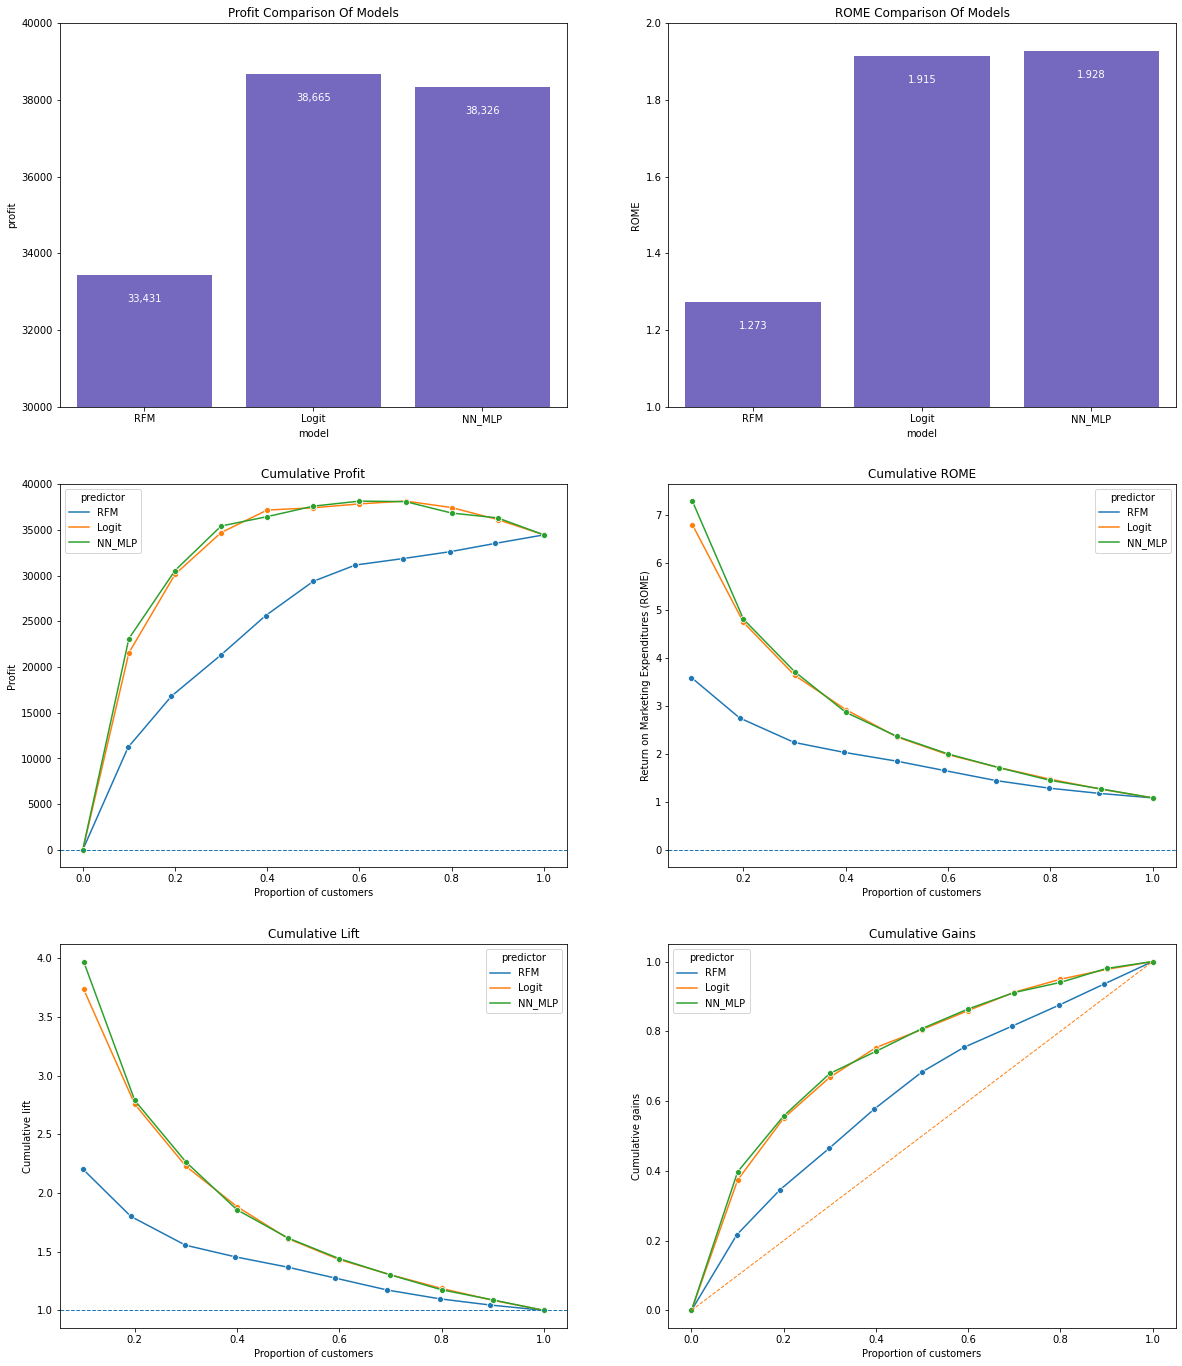

In [22]:
#Profit plot:
plot_data = final_result.copy()
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize = (20, 24))
sns.barplot(x="predictor", y="profit", color="slateblue", data=plot_data, ax = ax1)
ax1.set(xlabel="model", ylabel="profit")
ax1.set(ylim=(30000, 40000))
ax1.set_title("Profit Comparison Of Models")
for index, row in plot_data.iterrows():
    ax1.text(
        row.name, row.profit - 700, f"{int(row.profit):,}", ha="center", color="white"
    )
sns.barplot(x="predictor", y="ROME", color="slateblue", data=plot_data, ax = ax2)
ax2.set(xlabel="model", ylabel="ROME")
ax2.set(ylim=(1, 2))
ax2.set_title("ROME Comparison Of Models")
for index, row in plot_data.iterrows():
    ax2.text(
        row.name, row.ROME-0.07, f"{round(row.ROME, 3)}", ha="center", color="white"
    )
intuit75k_test = intuit75k_test.rename(columns = {'res_rfm':'RFM', 'res_logit': 'Logit', 'res_mlp': 'NN_MLP'})
rsm.profit_plot(df = intuit75k_test, rvar = 'res1_yes', lev = 1, pred = ['RFM', 'Logit', 'NN_MLP'], cost = 1.41, margin = 60, ax = ax3)
rsm.ROME_plot(df = intuit75k_test, rvar = 'res1_yes', lev = 1, pred = ['RFM', 'Logit', 'NN_MLP'], cost = 1.41, margin = 60, ax = ax4)
rsm.lift_plot(df = intuit75k_test, rvar = 'res1', lev = 'Yes', pred = ['RFM', 'Logit', 'NN_MLP'], ax = ax5)
rsm.gains_plot(df = intuit75k_test, rvar = 'res1', lev = 'Yes', pred = ['RFM', 'Logit', 'NN_MLP'], ax = ax6)
ax3.set_title("Cumulative Profit")
ax4.set_title("Cumulative ROME")
ax5.set_title("Cumulative Lift")
ax6.set_title("Cumulative Gains")
plt.show()

In [23]:
final_result.sort_values(by = "profit", ascending = False, inplace = True)
final_result[['predictor','contact', 'profit', 'ROME', 'Fscore', 'precision', 'TP', 'TN', 'FP', 'FN']]

,predictor,contact,profit,ROME,Fscore,precision,TP,TN,FP,FN
1,Logit,0.637,38665.98,1.915,0.127,0.068,981,8056,13341,122
2,NN_MLP,0.626,38326.05,1.928,0.128,0.069,970,8272,13125,133
0,RFM,0.828,33431.70,1.273,0.101,0.053,995,3762,17635,108


- **Profit** is the most important metric in this case. Therefore, we would adopt profit to choose our best model. Here, we consider $$Actual\ Profit(wave1) = TP \times margin - (TP + FP)\times cost$$ Based on this calculation, Logistic Regression outperforms the other by giving out the highest wave1 actual profit. 
    
- Because the actual profit seen in the table are rather similar to each other, we would examine the efficiency aspect as well. Based on the cumulative plots of profit, ROME, Lift and Gains, they indicate that Neural Network model is better at ranking the most-likely responded business. The top 40% customers generates a higher profit and efficiency in wielding money.

- Besides financial metrics, we would also take a look at the ML evaluation metric of Fscore and precision. Fscore put emphasis on both precision and recall of the model. A higher precision indicates we are good at targeting the respond customers, and a higher recall indicates that we are good at finding all potential-respond customers. To maximize the efficiency of wielding our money resources, we would want a higher Fscore. We can see that logistic regression and neural networks have very similar F1 and precision score from the table. Considering the principle of Occam's Razor, we would still go for the logistic model due to its simplicity and better interpretive power.

### 4.4 Wave2 Profit Estimation

$Profit\space=Total\ Margin -Total\ Cost$

$Total\ Margin = Total\ *Estimated\ Contact\ Rate \times\ Estimated\ Conversion\ Rate\times Margin$

$Total\ Cost = Total\ *Estimated\ Contact\ Rate \times\ Cost$

* Estimated Contact Rate = The percentage of test set we choose to contact, using the predicted wave2 response probability
* Estimated Conversion Rate = The percentage of actual respondents among our contacts based on the predicted wave1 response probability. 

In [24]:
margin = 60
cost = 1.41
intuit75k_test['res_wave_2'] = 0.5 * intuit75k_test['Logit']
estimated_contact_rate = intuit75k_test[intuit75k_test['res_wave_2'] >= breakeven].shape[0] / intuit75k_test.shape[0]
estimated_conversion_rate = intuit75k_test[intuit75k_test['Logit'] >= breakeven]['res1_yes'].sum() / intuit75k_test[intuit75k_test['Logit'] >= breakeven].shape[0]
total = 801821 - 38487
total_margin = total * estimated_contact_rate * estimated_conversion_rate * margin
total_cost = total * estimated_contact_rate * cost
scaled_profit = total_margin - total_cost
scaled_profit

635739.9241812226

In [25]:
print(f'''
Using the logistic regression to predict the total profit of the wave2 campaign, we should contact {round(estimated_contact_rate * 100, 2)}% (i.e. {round(total * estimated_contact_rate):,} businesses) with an estiamted conversion rate of {round(estimated_conversion_rate * 100, 2)}%.
That would gives us an estiamted profit of ${round(scaled_profit):,}.
''')


Using the logistic regression to predict the total profit of the wave2 campaign, we should contact 30.85% (i.e. 235,480 businesses) with an estiamted conversion rate of 6.85%.
That would gives us an estiamted profit of $635,740.



## 5. Conclusion

Through exploratory analysis and model development, we found that businesses that have heavier tax liabilities or accounting needs are more likely to upgrade since the quickbook can be a critical tool for their business. Businesses that used quickbook for a longer time and previously upgraded are more likely to upgrade this time as they could be our loyal customers.

Among RFM, Logistic Regression and Neural Networks, we used features of zip_bins, bizflag, numords, dollars, last, version1, owntaxprod, upgraded to get the best model of logistic regression with best performance on test set of \\$38665.98 profit. Using the estimated contact rate and conversion rate derived from the model, we scale the profit to the total of 763,334 businesses that didn't respond in wave1. The estimated profit of wave2 compagin is $635,740. 

## Appendix: Export the mail list on test dataset

We multiply the best model's predicted response probability for wave-1 by 0.5 to get its estimated response probability for wave-2. 

And if the business's estimated response probability for wave-2 is larger than breakeven and also it did not respond in wave-1, we will mail in wave-2.

In [26]:
intuit75k_test["mailto_wave2"] = rsm.ifelse((intuit75k_test.res1 != "Yes") & (intuit75k_test.res_wave_2 > breakeven), True, False)
intuit75k_test[['id', 'mailto_wave2']].to_csv('Xinshu_Qi_Chenyuan_Xiangyu_WonderFourEver.csv', index = False)